In [21]:
import pandas as pd
import numpy as np

data = pd.read_csv('data_for_model.csv', index_col=[0]).reset_index(level=0, drop=True)
data

,season,round,home_club_position,away_club_position,home_club_cum_goals,away_club_cum_goals,home_club_cum_concede,away_club_cum_concede,home_recent_result,away_recent_result,result
0,2013,1,5,18,0,0,0,0,0,0,1
1,2013,1,11,10,0,0,0,0,0,0,0
2,2013,1,14,7,0,0,0,0,0,0,-1
3,2013,1,1,20,0,0,0,0,0,0,1
4,2013,1,6,13,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3795,2022,38,12,4,37,67,46,32,4,8,0
3796,2022,38,17,15,33,37,57,70,5,6,1
3797,2022,38,7,6,49,71,45,51,7,9,1
3798,2022,38,9,1,57,94,46,32,12,15,1


# Training / Testing Set Division

test_size = 0.2, test the most recent seasons (2021 / 2022) by training the model with 8 previous seasons (2013 - 2020)

In [22]:
# Except round 1 (with no supportive features)

data = data.loc[data['round'] != 1].reset_index(drop=True)

In [23]:
X_train = data[(data['season'] != 2021) & (data['season'] != 2022)].drop(columns='result')
y_train = data[(data['season'] != 2021) & (data['season'] != 2022)]['result']
X_test = data[(data['season'] == 2021) | (data['season'] == 2022)].drop(columns='result')
y_test = data[(data['season'] == 2021) | (data['season'] == 2022)]['result']

X_train.replace(np.NaN, 0, inplace=True)
X_test.replace(np.NaN, 0, inplace=True)

In [24]:
X_train[(X_train['season'] == 2013) & (X_train['round'] == 38)]

,season,round,home_club_position,away_club_position,home_club_cum_goals,away_club_cum_goals,home_club_cum_concede,away_club_cum_concede,home_recent_result,away_recent_result
360,2013,38,18,4,28,66,60,41,1,12
361,2013,38,17,9,42,43,57,51,7,7
362,2013,38,1,13,100,40,37,49,12,3
363,2013,38,14,12,40,51,57,53,9,6
364,2013,38,8,7,53,63,45,42,7,9
365,2013,38,19,11,38,31,83,46,7,10
366,2013,38,6,15,52,39,51,58,10,4
367,2013,38,16,5,38,59,51,39,4,9
368,2013,38,2,10,99,42,49,57,10,3
369,2013,38,20,3,31,69,72,26,4,10


# Data Scaler

### Standardization // Normalization // PCA

In [12]:
# Scaling between 0 and 1

def cumulative_scaler(data: pd.DataFrame):
    columns_to_change = ['home_club_cum_goals', 'away_club_cum_goals', 'home_club_cum_concede', 'away_club_cum_concede', 'home_recent_result', 'away_recent_result']
    data_scaled = data.copy()
    data_scaled[columns_to_change] = data_scaled.groupby(['season', 'round'])[columns_to_change].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    return data_scaled

X_train_scaled = cumulative_scaler(X_train)
X_test_scaled = cumulative_scaler(X_test)

In [5]:
# def against_ratio(data: pd.DataFrame):
#     data_scaled = data.copy()
#     data_scaled['home_win_ratio'] = data_scaled['home_win'] / (data_scaled['home_win'] + data_scaled['draw'] + data_scaled['away_win'])
#     data_scaled['draw_ratio'] = data_scaled['draw'] / (data_scaled['home_win'] + data_scaled['draw'] + data['away_win'])
#     data_scaled['away_win_ratio'] = data_scaled['away_win'] / (data_scaled['home_win'] + data_scaled['draw'] + data_scaled['away_win'])

#     data_scaled.drop(columns=['home_win', 'draw', 'away_win'], inplace=True)
#     return data_scaled

# X_train_scaled = against_ratio(X_train_scaled)
# X_test_scaled = against_ratio(X_test_scaled)

In [15]:
def standardization(data: pd.DataFrame):
    # to_convert = ['home_club_position', 'away_club_position', 'home_value', 'away_value']
    to_convert = ['home_club_position', 'away_club_position']
    data_scaled = data.copy()
    data_scaled[to_convert] = data_scaled[to_convert].apply(lambda x: x / x.max())
    return data_scaled

X_train_scaled = standardization(X_train_scaled)
X_test_scaled = standardization(X_test_scaled)

In [20]:
X_train_scaled[(X_train_scaled['season'] == 2013) & (X_train_scaled['round'] == 38)]

,season,round,home_club_position,away_club_position,home_club_cum_goals,away_club_cum_goals,home_club_cum_concede,away_club_cum_concede,home_recent_result,away_recent_result
360,2013,38,0.90,0.20,0.000000,0.921053,0.500000,0.46875,0.000000,1.000000
361,2013,38,0.85,0.45,0.194444,0.315789,0.434783,0.78125,0.545455,0.444444
362,2013,38,0.05,0.65,1.000000,0.236842,0.000000,0.71875,1.000000,0.000000
363,2013,38,0.70,0.60,0.166667,0.526316,0.434783,0.84375,0.727273,0.333333
364,2013,38,0.40,0.35,0.347222,0.842105,0.173913,0.50000,0.545455,0.666667
365,2013,38,0.95,0.55,0.138889,0.000000,1.000000,0.62500,0.545455,0.777778
366,2013,38,0.30,0.75,0.333333,0.210526,0.304348,1.00000,0.818182,0.111111
367,2013,38,0.80,0.25,0.138889,0.736842,0.304348,0.40625,0.272727,0.666667
368,2013,38,0.10,0.50,0.986111,0.289474,0.260870,0.96875,0.818182,0.000000
369,2013,38,1.00,0.15,0.041667,1.000000,0.760870,0.00000,0.272727,0.777778


In [7]:
X_train_scaled.drop(columns=['season', 'round'], inplace=True)
X_test_scaled.drop(columns=['season', 'round'], inplace=True)

X_train_scaled.replace(np.NaN, 0, inplace=True)
X_test_scaled.replace(np.NaN, 0, inplace=True)

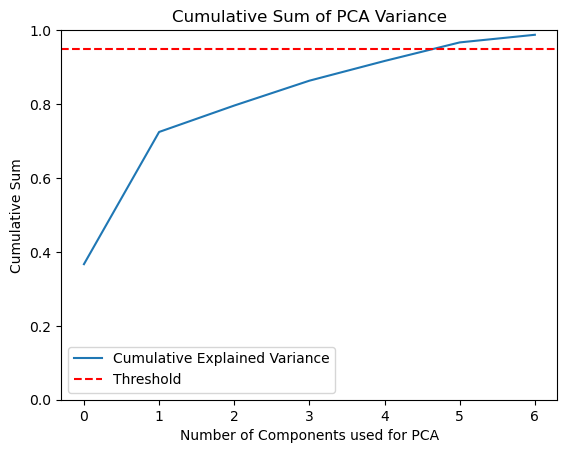

In [11]:
# PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# A good strategy is to choose the number of dimensions for which the cumulative explained variance exceeds a threshold, e.g., 0.95 (95%).

for i in range(1, len(X_train_scaled.columns)):
    pca = PCA(n_components=i)
    pca.fit(X_train_scaled)
    cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.style.use('default')
plt.plot(cumsum, label="Cumulative Explained Variance")
plt.title("Cumulative Sum of PCA Variance")
plt.xlabel("Number of Components used for PCA")
plt.ylabel("Cumulative Sum")
plt.ylim([0, 1])
plt.axhline(0.95, color="r", linestyle="--", label="Threshold")
plt.legend()    
plt.show()

In [9]:
# pca = PCA(n_components=5)

# X_train_scaled = pca.fit_transform(X_train_scaled)
# X_test_scaled = pca.transform(X_test_scaled)

# Models

- Multinomial Logistic Regression / `Discriminant Analysis (Linear / Quadratic) / Naive Bayes Classifier
- K-Nearest Neighbors
- Decision Tree

to calculate performance --> Confusion Matrix / Classification Report (Accuracy / Precision / Recall / f1 score)

# Multinomial Logistic Regression

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# C = Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
# The model won't fit with elastic model

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
    'multi_class': ['multinomial'],
    'fit_intercept': [True, False],
    'tol': [0.0001, 0.001, 0.01]
}

lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid=param_grid, cv=5, scoring="accuracy")
grid.fit(X_train_scaled, y_train)
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score').reset_index(drop=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,param_multi_class,param_penalty,param_solver,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007400,0.000490,0.001201,0.000399,1,True,multinomial,l2,sag,0.01,"{'C': 1, 'fit_intercept': True, 'multi_class':...",0.635135,0.606419,0.604730,0.633446,0.619932,0.619932,0.012864,1
1,0.019701,0.001780,0.001601,0.000490,1,True,multinomial,l2,lbfgs,0.01,"{'C': 1, 'fit_intercept': True, 'multi_class':...",0.638514,0.603041,0.604730,0.636824,0.616554,0.619932,0.015221,2
2,0.019566,0.001373,0.001601,0.000490,1,True,multinomial,l2,newton-cg,0.01,"{'C': 1, 'fit_intercept': True, 'multi_class':...",0.638514,0.603041,0.604730,0.636824,0.616554,0.619932,0.015221,2
3,0.012800,0.001328,0.001599,0.000490,1,True,multinomial,l2,sag,0.0001,"{'C': 1, 'fit_intercept': True, 'multi_class':...",0.638514,0.603041,0.604730,0.636824,0.616554,0.619932,0.015221,2
4,0.009389,0.001003,0.002211,0.001490,1,True,multinomial,l2,saga,0.0001,"{'C': 1, 'fit_intercept': True, 'multi_class':...",0.638514,0.603041,0.604730,0.636824,0.616554,0.619932,0.015221,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.006570,0.000470,0.001400,0.000490,0.001,True,multinomial,l2,lbfgs,0.001,"{'C': 0.001, 'fit_intercept': True, 'multi_cla...",0.466216,0.462838,0.467905,0.467905,0.466216,0.466216,0.001850,158
164,0.006187,0.000381,0.001611,0.000498,0.001,True,multinomial,l2,lbfgs,0.01,"{'C': 0.001, 'fit_intercept': True, 'multi_cla...",0.466216,0.462838,0.467905,0.467905,0.466216,0.466216,0.001850,158
165,0.009342,0.001479,0.002003,0.000002,0.001,True,multinomial,l2,sag,0.0001,"{'C': 0.001, 'fit_intercept': True, 'multi_cla...",0.466216,0.462838,0.467905,0.467905,0.466216,0.466216,0.001850,158
166,0.015790,0.001436,0.002600,0.000800,0.001,True,multinomial,l2,newton-cg,0.0001,"{'C': 0.001, 'fit_intercept': True, 'multi_cla...",0.466216,0.462838,0.467905,0.467905,0.466216,0.466216,0.001850,158


In [9]:
# Multinomial Logistic Regression
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(multi_class='multinomial', penalty="l2", solver="sag", C=1, tol=0.001)
logistic.fit(X_train_scaled, y_train)

train_pred = logistic.predict(X_train_scaled)
test_pred = logistic.predict(X_test_scaled)
print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

          -1       0.59      0.74      0.66       930
           0       0.40      0.03      0.06       691
           1       0.65      0.84      0.73      1339

    accuracy                           0.62      2960
   macro avg       0.55      0.54      0.48      2960
weighted avg       0.57      0.62      0.55      2960

              precision    recall  f1-score   support

          -1       0.57      0.73      0.64       231
           0       0.44      0.02      0.04       173
           1       0.64      0.83      0.72       336

    accuracy                           0.61       740
   macro avg       0.55      0.53      0.47       740
weighted avg       0.57      0.61      0.54       740



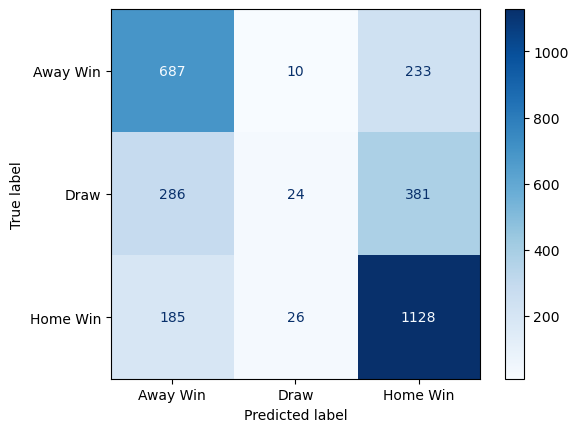

In [12]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred=train_pred, y_true=y_train), display_labels=['Away Win', 'Draw', 'Home Win'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

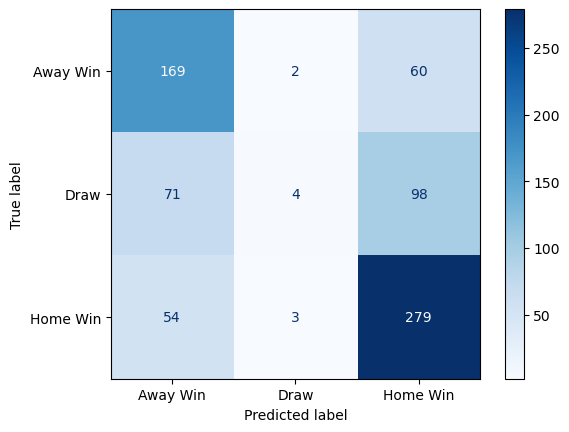

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred=test_pred, y_true=y_test), display_labels=['Away Win', 'Draw', 'Home Win'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

<Axes: ylabel='Feature'>

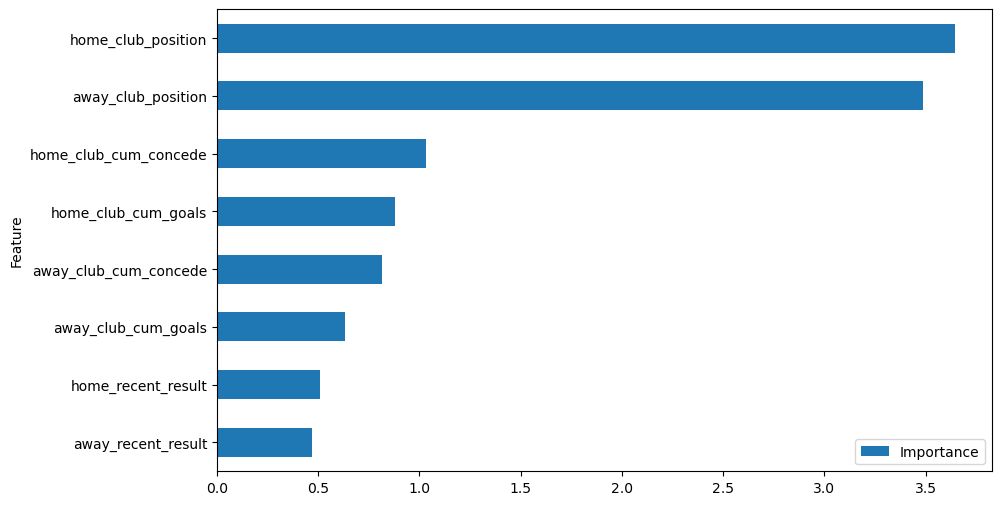

In [14]:
# Feature Importance Scale --> Based on the absolute value of coefficients

coefficients = logistic.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [16]:
prediction = np.concatenate((train_pred, test_pred))
data.loc[:, 'multinomial_result'] = pd.Series(prediction)

# Knn

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid={'n_neighbors': [i for i in range(1, 30)]}, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score').reset_index(drop=True)

NameError: name 'GridSearchCV' is not defined

In [16]:
# K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train_scaled, y_train)

train_pred = knn.predict(X_train_scaled)
test_pred = knn.predict(X_test_scaled)
print(classification_report(y_true=y_test, y_pred=test_pred))
print(classification_report(y_true=y_train, y_pred=train_pred))

              precision    recall  f1-score   support

          -1       0.54      0.61      0.57       231
           0       0.27      0.11      0.16       173
           1       0.63      0.77      0.70       336

    accuracy                           0.57       740
   macro avg       0.48      0.50      0.47       740
weighted avg       0.52      0.57      0.53       740

              precision    recall  f1-score   support

          -1       0.60      0.70      0.64       930
           0       0.40      0.13      0.20       691
           1       0.65      0.81      0.72      1339

    accuracy                           0.62      2960
   macro avg       0.55      0.54      0.52      2960
weighted avg       0.58      0.62      0.58      2960



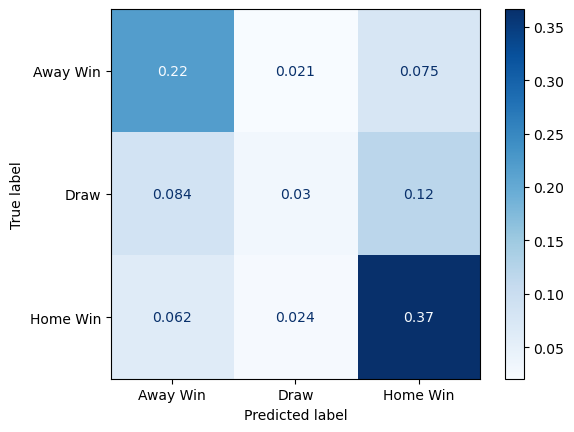

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred=train_pred, y_true=y_train, normalize='all'), display_labels=['Away Win', 'Draw', 'Home Win'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

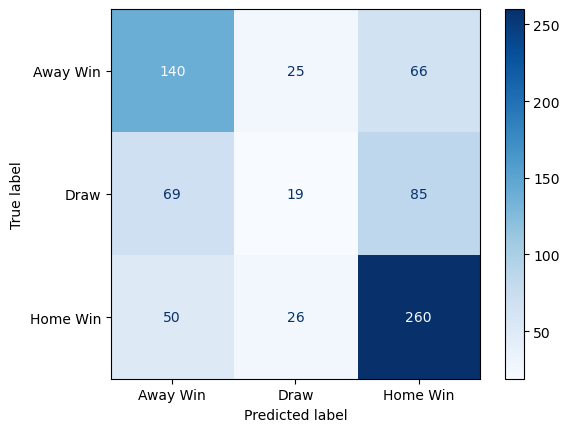

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred=test_pred, y_true=y_test), display_labels=['Away Win', 'Draw', 'Home Win'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [21]:
prediction = np.concatenate((train_pred, test_pred))
data.loc[:, 'knn_result'] = pd.Series(prediction)

# Decision Tree

In [22]:
dtree_model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 15),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': ['sqrt', 'log2'],
    'min_impurity_decrease': np.arange(0.0, 0.5, 0.1)
}

grid = GridSearchCV(dtree_model, param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score').reset_index(drop=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002801,4.005478e-04,0.001600,4.895542e-04,gini,5,log2,0.0,7,5,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.603041,0.574324,0.587838,0.572635,0.581081,0.583784,0.011030,1
1,0.003200,3.997572e-04,0.002000,1.548527e-03,entropy,4,log2,0.0,1,3,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.604730,0.559122,0.614865,0.552365,0.587838,0.583784,0.024562,1
2,0.004000,6.321841e-04,0.001000,8.583069e-07,entropy,5,log2,0.0,1,3,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.608108,0.567568,0.608108,0.581081,0.550676,0.583108,0.022572,3
3,0.003200,3.993041e-04,0.001200,3.994943e-04,gini,5,log2,0.0,1,2,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.591216,0.576014,0.604730,0.570946,0.570946,0.582770,0.013258,4
4,0.003000,1.162153e-06,0.001000,8.259062e-07,entropy,4,log2,0.0,1,5,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.572635,0.581081,0.597973,0.594595,0.562500,0.581757,0.013284,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,0.001601,4.898825e-04,0.001199,3.995661e-04,gini,11,log2,0.3,5,6,"{'criterion': 'gini', 'max_depth': 11, 'max_fe...",0.451014,0.452703,0.452703,0.452703,0.452703,0.452365,0.000676,4416
17276,0.002000,6.843901e-07,0.001200,3.999951e-04,gini,11,log2,0.3,5,7,"{'criterion': 'gini', 'max_depth': 11, 'max_fe...",0.451014,0.452703,0.452703,0.452703,0.452703,0.452365,0.000676,4416
17277,0.001800,3.998774e-04,0.001001,8.996946e-07,gini,11,log2,0.3,5,8,"{'criterion': 'gini', 'max_depth': 11, 'max_fe...",0.451014,0.452703,0.452703,0.452703,0.452703,0.452365,0.000676,4416
17278,0.002000,1.081065e-06,0.001000,8.203817e-07,gini,11,log2,0.3,4,4,"{'criterion': 'gini', 'max_depth': 11, 'max_fe...",0.451014,0.452703,0.452703,0.452703,0.452703,0.452365,0.000676,4416


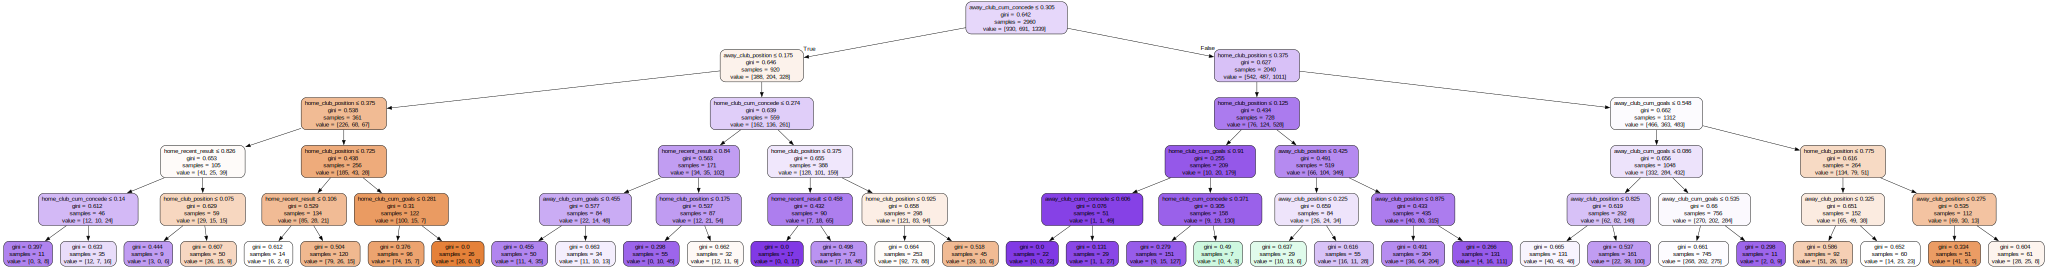

<Figure size 10000x6000 with 0 Axes>

In [20]:
from sklearn.tree import DecisionTreeClassifier

import graphviz
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=5, max_features='sqrt', criterion='gini', min_impurity_decrease=0, min_samples_leaf=5, min_samples_split=9)
clf.fit(X_train_scaled, y_train)
test_pred = clf.predict(X_test_scaled)
train_pred = clf.predict(X_train_scaled)

plt.figure(figsize=(100, 60))
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_train_scaled.columns,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [21]:
print(classification_report(y_true=y_test, y_pred=test_pred))
print(classification_report(y_true=y_train, y_pred=train_pred))

              precision    recall  f1-score   support

          -1       0.53      0.42      0.47       231
           0       0.33      0.05      0.08       173
           1       0.55      0.86      0.67       336

    accuracy                           0.54       740
   macro avg       0.47      0.44      0.41       740
weighted avg       0.49      0.54      0.47       740

              precision    recall  f1-score   support

          -1       0.55      0.50      0.52       930
           0       0.42      0.06      0.10       691
           1       0.56      0.85      0.68      1339

    accuracy                           0.56      2960
   macro avg       0.51      0.47      0.43      2960
weighted avg       0.53      0.56      0.49      2960



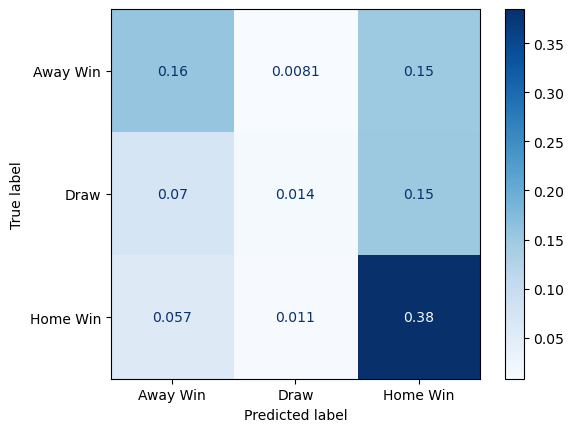

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred=train_pred, y_true=y_train, normalize='all'), display_labels=['Away Win', 'Draw', 'Home Win'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

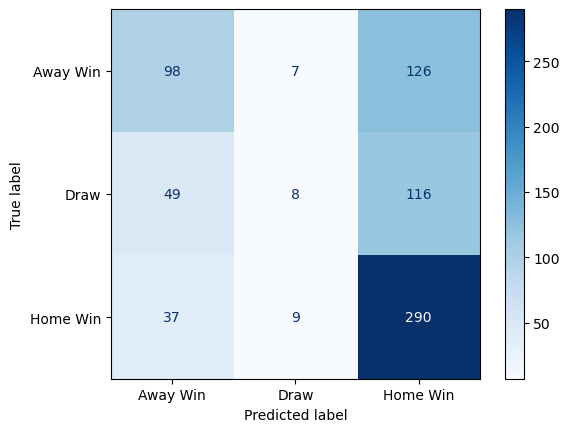

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred=test_pred, y_true=y_test), display_labels=['Away Win', 'Draw', 'Home Win'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

<Axes: ylabel='Feature'>

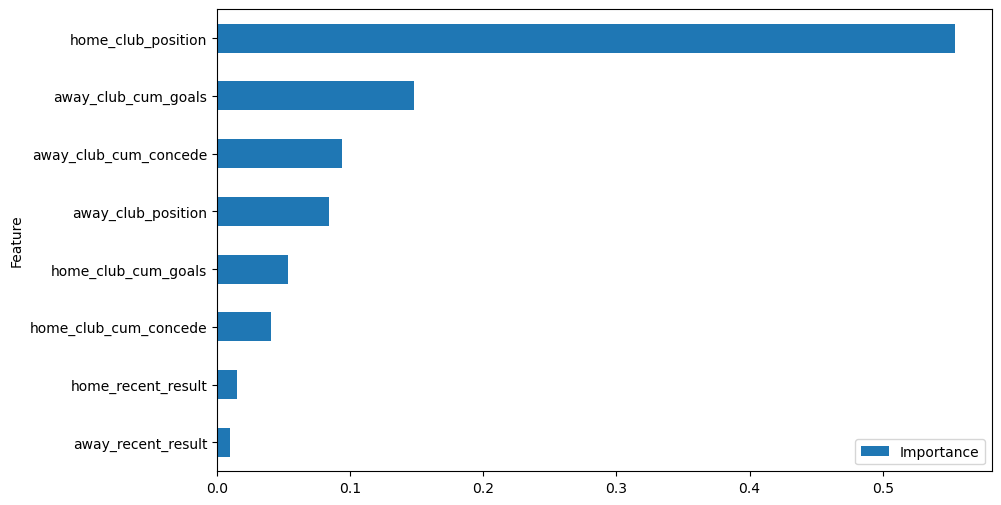

In [27]:
coefficients = clf.feature_importances_

feature_importance = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [28]:
prediction = np.concatenate((train_pred, test_pred))
data.loc[:, 'tree_result'] = pd.Series(prediction)

In [29]:
data.to_csv('results_combined.csv')